In [1]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Measurement.metadata.tables['measurement'].columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [9]:
Station = Base.classes.station
Station.metadata.tables['station'].columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

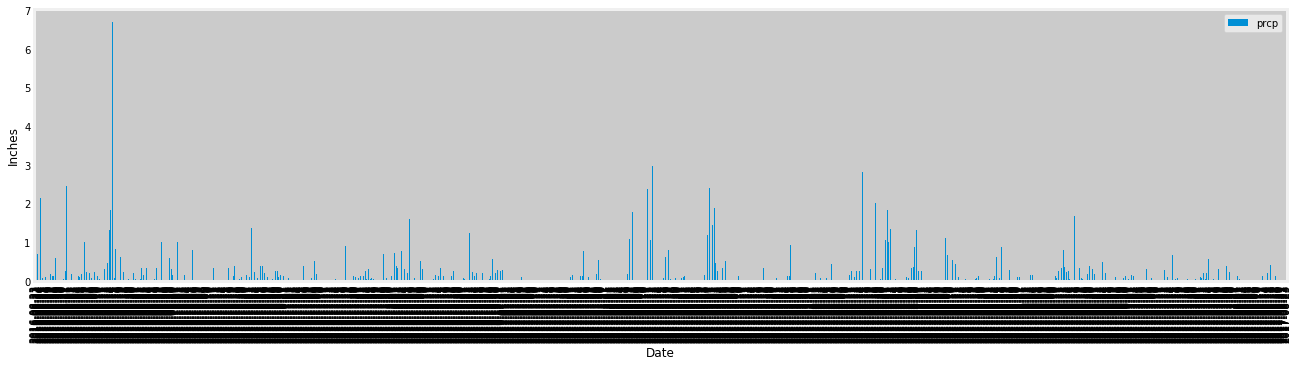

<Figure size 432x288 with 0 Axes>

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
prcp_data = pd.read_sql("SELECT date, prcp FROM measurement WHERE date >= '2016-08-23' ORDER BY date ASC", conn)
prcp_data.dropna(inplace=True)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data_2 = prcp_data.set_index('date')
#prcp_data_2

# Use Pandas Plotting with Matplotlib to plot the data
prcp_data_2.plot(kind="bar",figsize=(20,5))
plt.style.use('fivethirtyeight')
plt.xlabel("Date")
plt.ylabel("Inches")

plt.show()
plt.tight_layout()


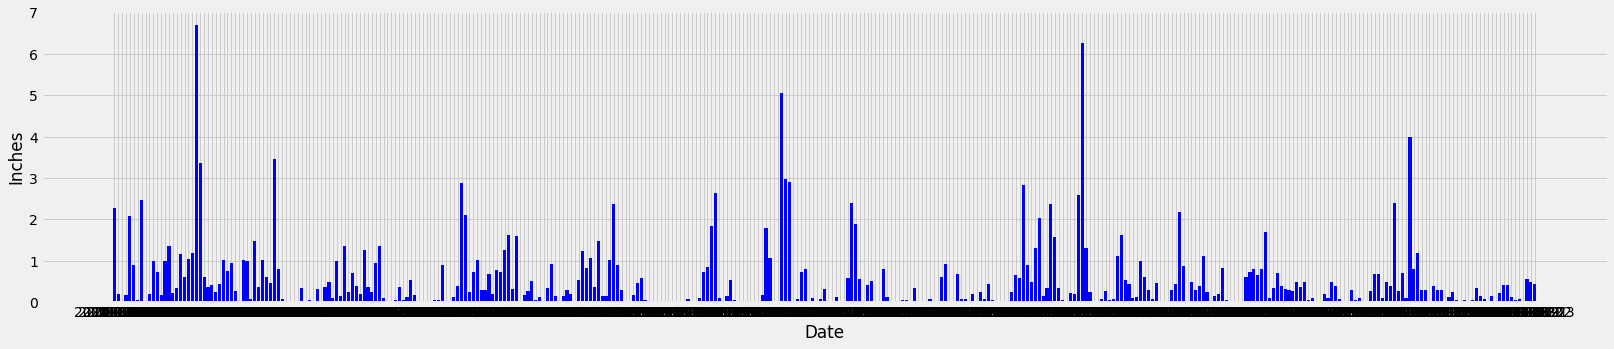

In [13]:
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-24').\
    filter(Measurement.prcp != None).\
    order_by(Measurement.date).all()

prcp_x = [prcp[0] for prcp in prcp_data]
prcp_y = [prcp[1] for prcp in prcp_data]
plt.figure(figsize=(25,5))
plt.style.use('fivethirtyeight')
plt.bar(prcp_x, prcp_y, color='b', align="center")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data_2.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_data = pd.read_sql("SELECT station, count(id) FROM measurement GROUP BY station ORDER BY count(id) DESC", conn)
station_data

,station,count(id)
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [17]:
session.query(Measurement.station,func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id)).all()

[('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00511918', 1979),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00519523', 2669),
 ('USC00513117', 2709),
 ('USC00519397', 2724),
 ('USC00519281', 2772)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()

(85.0)

In [19]:
session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()

(54.0)

In [20]:
session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()

(71.66378066378067)

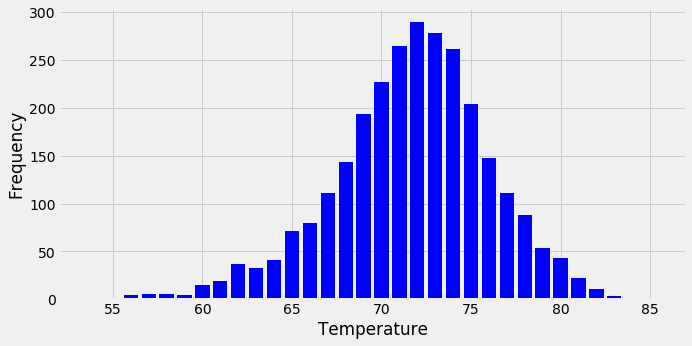

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.tobs,func.count(Measurement.id)).filter(Measurement.station == 'USC00519281').group_by(Measurement.tobs).all()
x = [temp[0] for temp in temp_data]
y = [temp[1] for temp in temp_data]
plt.figure(figsize=(10,5))
plt.bar(x, y, color='b', align="center")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

## Bonus Challenge Assignment

In [23]:
june_df = pd.read_sql("SELECT date, tobs FROM measurement WHERE date LIKE '____-06-__' ORDER BY date ASC", conn)
dec_df = pd.read_sql("SELECT date, tobs FROM measurement WHERE date LIKE '____-12-__' ORDER BY date ASC", conn)
june_df["tobs"].mean()

74.94411764705882

In [24]:
dec_df["tobs"].mean()

71.04152933421226

In [25]:
stats.ttest_ind(june_df.tobs, dec_df.tobs, equal_var=False)

Ttest_indResult(statistic=31.35503692096242, pvalue=4.193529835915755e-187)

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps('2017-03-01', '2017-03-10')
trip_temp 

[(62.0, 70.33870967741936, 78.0)]

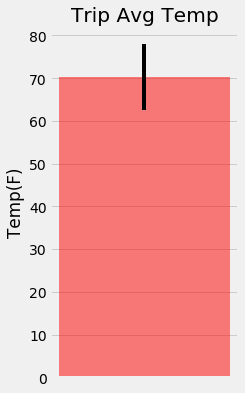

In [36]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_temp = trip_temp[0][1]
error = trip_temp[0][2] - trip_temp[0][1]
x_axis = 1
plt.figure(figsize=(3,6))
plt.bar(x_axis, avg_temp, yerr=error,alpha=0.5, color='red', align='center')
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")
plt.xticks([])
plt.show()
plt.show()

In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_start = '2017-03-01'
trip_end = '2017-03-10'

sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
result = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= trip_start).\
    filter(Measurement.date <= trip_end).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print (result)

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 5.7299999999999995), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 5.390000000000001), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 3.5), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 2.98), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 2.7399999999999998), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 2.32), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.75)]


In [35]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [59]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date


date_list = []
for x in range(1,11):
    date = dt.date(2017, 3 ,x)
    date2 = date.strftime("%m-%d")
    date_list.append(date2)
    
normals = []
for x in date_list:
    y = daily_normals(x)
    normals.append(y)   
normals


[[(64.0, 70.0327868852459, 76.0)],
 [(61.0, 70.36666666666666, 78.0)],
 [(60.0, 70.06896551724138, 78.0)],
 [(57.0, 69.27272727272727, 77.0)],
 [(60.0, 67.89090909090909, 76.0)],
 [(60.0, 69.20338983050847, 76.0)],
 [(60.0, 69.17241379310344, 78.0)],
 [(59.0, 68.72413793103448, 78.0)],
 [(57.0, 68.56140350877193, 75.0)],
 [(57.0, 69.12280701754386, 75.0)]]

In [74]:
t_min = [normals[x][0][0] for x in range(0,10)]
t_avg = [normals[x][0][1] for x in range(0,10)]    
t_max = [normals[x][0][2] for x in range(0,10)]

In [77]:
normals_df = pd.DataFrame({
    "date": date_list,
    "tmin": t_min,
    "tavg": t_avg,
    "tmax": t_max
})
normals_df.set_index('date', inplace=True)
normals_df

,tmin,tavg,tmax
date,,,
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0
03-05,60.0,67.890909,76.0
03-06,60.0,69.203390,76.0
03-07,60.0,69.172414,78.0
03-08,59.0,68.724138,78.0
03-09,57.0,68.561404,75.0


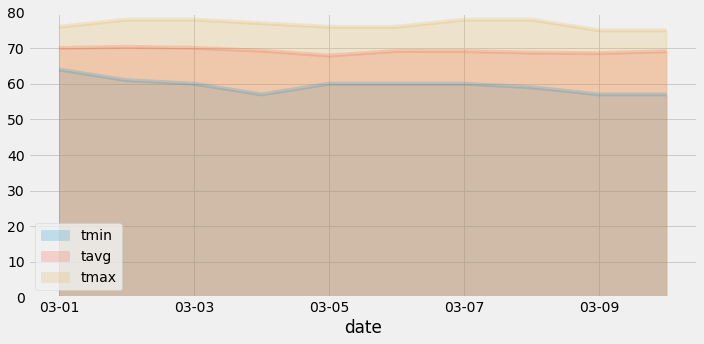

In [80]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, alpha=0.2,figsize=(10,5))
plt.xlabel("date")
plt.ylim(0, 80)
plt.tight_layout()